<a href="https://colab.research.google.com/github/yxmauw/eye-disease-classification/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up local directory to work
Stream data direct from kaggle using Kaggle API

In [ ]:
# install kaggle API
# !pip install kaggle

In [1]:
!git clone https://github.com/yxmauw/eye-disease-classification.git

Cloning into 'eye-disease-classification'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 111 (delta 61), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (111/111), 7.65 MiB | 6.47 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
!mkdir ~/.kaggle #Make a directory named “.kaggle”

In [3]:
!cp ./eye-disease-classification/kaggle.json ~/.kaggle/ # Copy the “kaggle.json” into this new directory

In [4]:
!chmod 600 ~/.kaggle/kaggle.json # Allocate the required permission for this file

In [5]:
!kaggle datasets download gunavenkatdoddi/eye-diseases-classification # download dataset

 98% 724M/736M [00:05<00:00, 119MB/s]
100% 736M/736M [00:05<00:00, 132MB/s]


In [ ]:
!unzip eye-diseases-classification.zip

## Explore images

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

### Number of images in dataset:

In [ ]:
import fnmatch
import os

# image files count
cataract_count = len(fnmatch.filter(os.listdir('./dataset/cataract'), '*.jpg'))
dre_count = len(fnmatch.filter(os.listdir('./dataset/diabetic_retinopathy'), '*.jpeg'))
glaucoma_count = len(fnmatch.filter(os.listdir('./dataset/glaucoma'), '*.jpg'))
normal_count = len(fnmatch.filter(os.listdir('./dataset/normal'), '*.jpg'))
total_image_count = cataract_count + dre_count + \
                    glaucoma_count + normal_count
# print count
print('---Categories---')
print('Cataract:', cataract_count)
print('Diabetic retinopathy:', dre_count)
print('Glaucoma:', glaucoma_count)
print('Normal', normal_count)
print()
print('---Total image count---')
print(total_image_count)

---Categories---
Cataract: 938
Diabetic retinopathy: 1098
Glaucoma: 906
Normal 1074

---Total image count---
4016


### Image dimensions, properties:

In [8]:
# load example image
from PIL import Image 
im = Image.open('./dataset/glaucoma/1495_left.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size) # size already 512 x 512

pixels = np.asarray(im)
print(pixels[0])
print(pixels.shape) # 3 channel last

JPEG
RGB
(512, 512)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
(512, 512, 3)


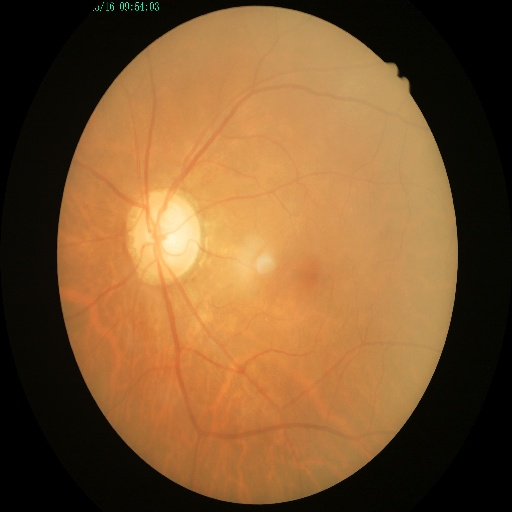

In [ ]:
#Import library
from IPython import display
display.Image(filename='./dataset/glaucoma/1495_left.jpg', width=200, height=150)

In [ ]:
# calculate image pixel mean, min, max

mean = pixels.mean()
print('Mean: %.3f' % mean)
# confirm pixel range is 0-255
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Mean: 86.173
Min: 0.000, Max: 255.000


## Visualise preprocessed images

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__) #2.8.2

2.8.2


What happens after resizing and rescaling: 

In [10]:
resize_and_rescale = tf.keras.Sequential([   
    layers.Resizing(160,160) ,  # needs to be symmetrical
    layers.Rescaling(1./255) # desired height, width in model pipeline
])

result = resize_and_rescale(pixels)
print(result.shape) # new shape, channels

(160, 160, 3)


What happens to image pixel values after rescaling:

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


Show images before and after preprocessing:

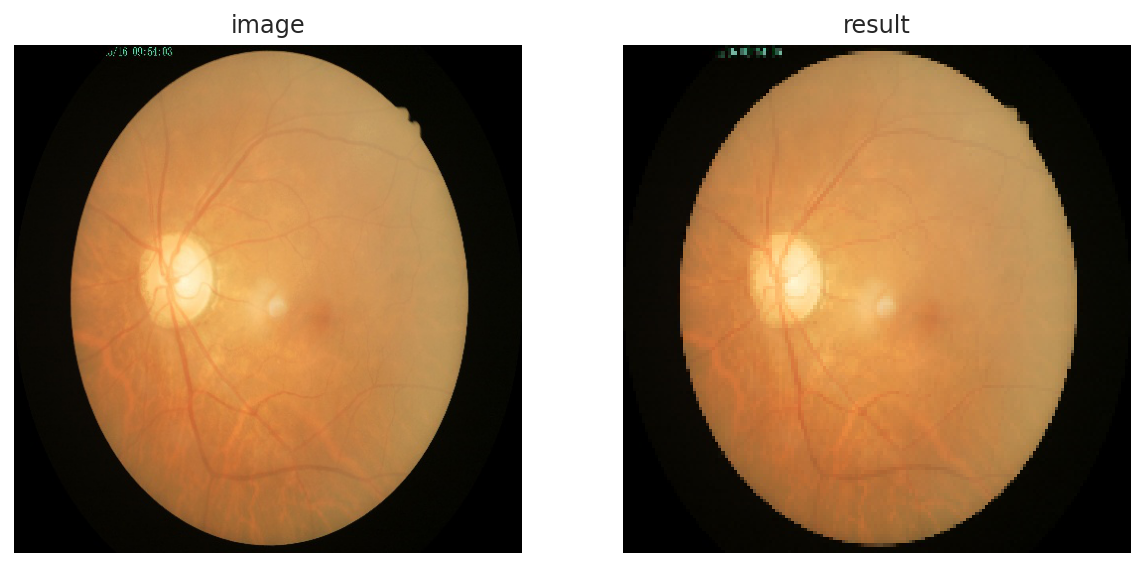

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,8))
ax0.imshow(im)
ax0.axis('off')
ax0.set_title('image')
# after pixel normalisation
ax1.imshow(result)
ax1.axis('off')
ax1.set_title('result')
plt.show() # result seems to have slight blurring of image, but still good definition

## Create train and validation datasets

In [11]:
# generate dataset that can be used for machine learning
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (160, 160) # very important to get this right, will determine model success
batch_size = 32

train_ds = image_dataset_from_directory(
    './dataset/',
    image_size=image_size,
    shuffle=True,
    seed=1,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    './dataset/',
    image_size=image_size,
    shuffle=True,
    seed=1,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical'
)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


### Visualise images and labels together

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


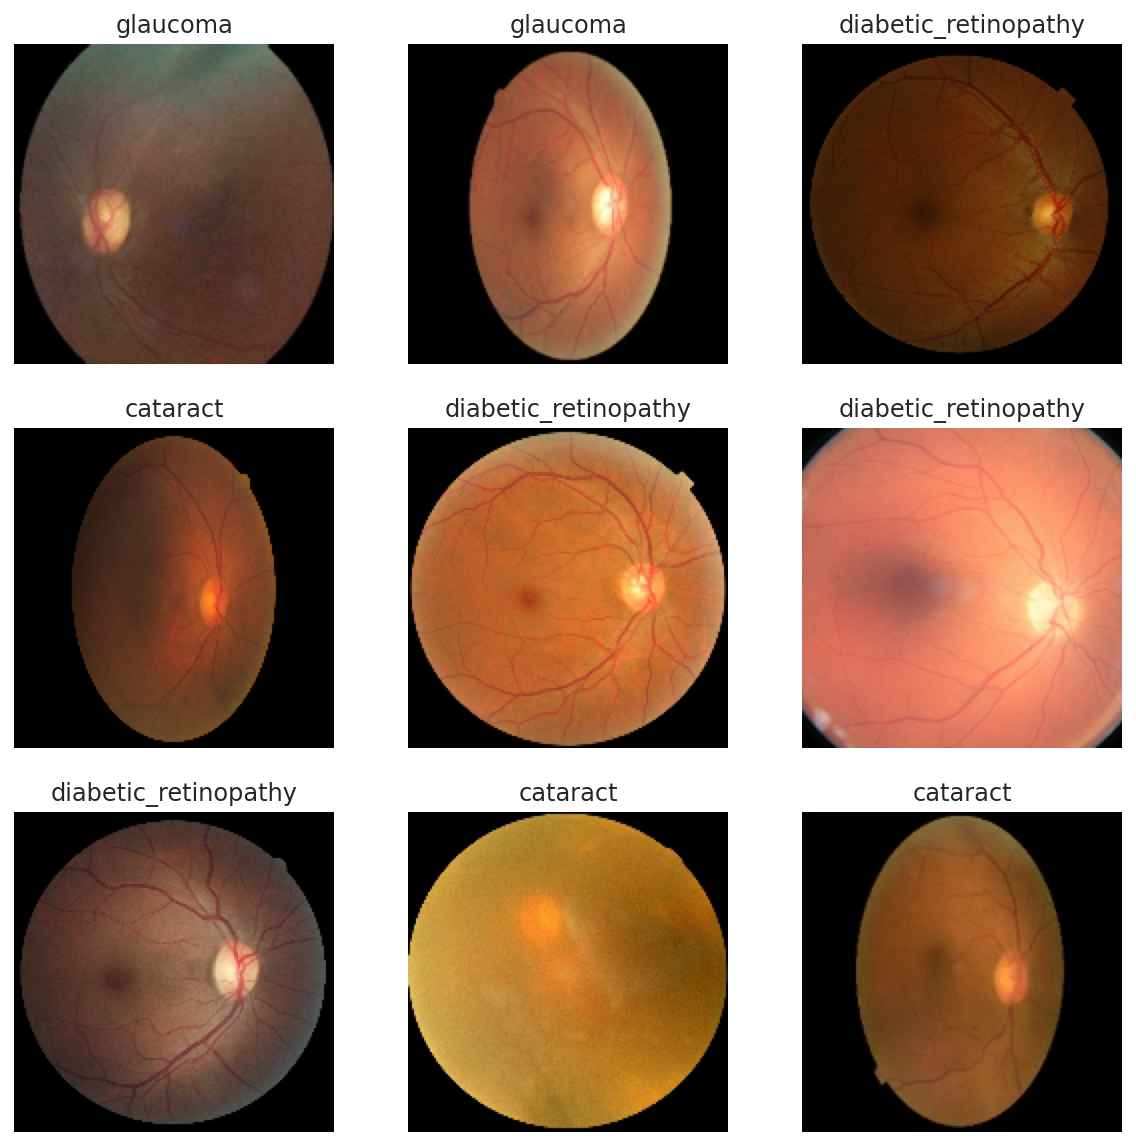

In [ ]:
# preview of how images are labelled
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # each image 160 x 160
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i], axis=0)])
    plt.axis("off")

## Configure datasets for optimal performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [13]:
data_augmentation = tf.keras.Sequential(
    [ layers.RandomFlip("horizontal_and_vertical", seed=1), 
      layers.RandomRotation(0.2, seed=2),
      layers.RandomContrast(0.2, seed=1)
    ])

### Visualise augmented images

In [ ]:
def augmented_img():
  for image, _ in train_ds.take(1):  # take a sample image from training set
    plt.figure(figsize=(8, 8))
    first_image = image[0]
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      plt.imshow(augmented_image[0] / 255) # rescale pixel 0 to 1
      plt.axis("off")

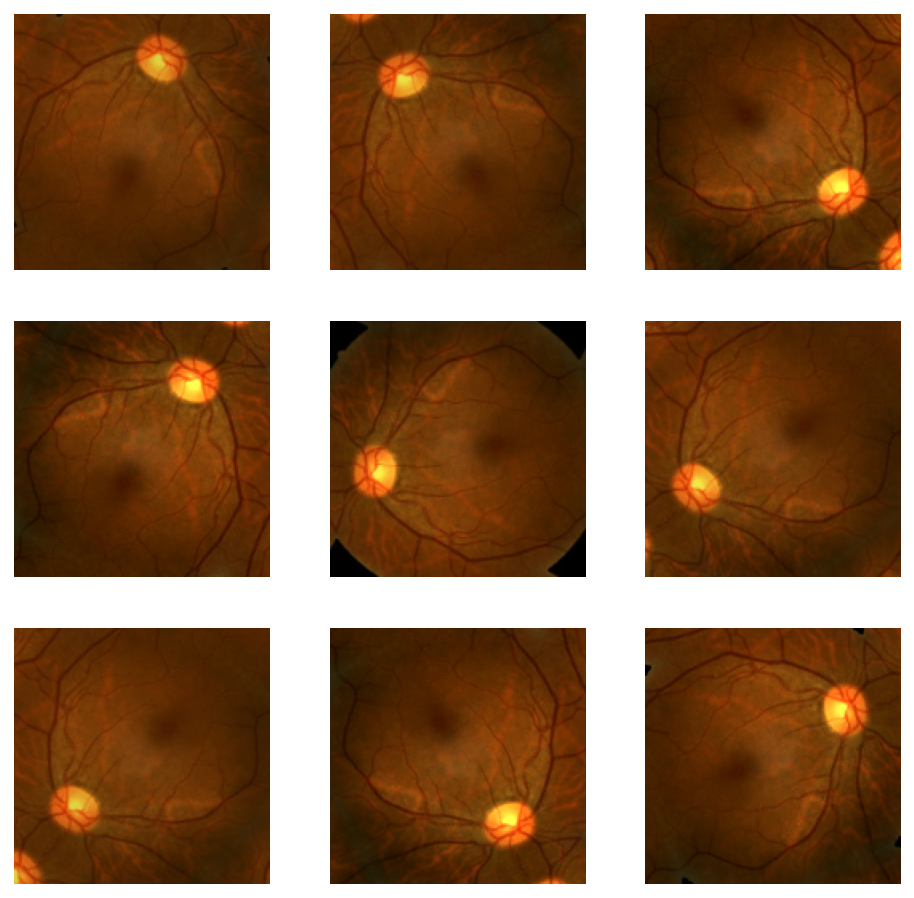

In [ ]:
augmented_img()

## Create Base UNet model

[UNet code architecture](https://blog.paperspace.com/unet-architecture-image-segmentation/)

<img src="https://miro.medium.com/max/1020/1*_azTISV4DteZd8hCSiQ7Dg.png" alt="UNet model" width="500" height="300">


In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [15]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

In [16]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [17]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [18]:
def U_Net(Image_Size): # without data augmentation
    # Take the image size and shape
    input1 = tf.keras.Input(Image_Size)
    # rescale
    input1 = layers.Rescaling(1./255)(input1)

    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out_1 = Conv2D(4, 1, padding="same", activation="relu")(decoder_4)
    #final layers to force shape to suit binary label shapes
    flat = tf.keras.layers.Flatten()(out_1)
    out_2 = tf.keras.layers.Dense(4, activation='softmax')(flat)

    model = Model(input1, out_2)
    return model

In [ ]:
input_shape = (160, 160, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 64  256        ['conv2d[1][0]']                 
 alization)                     )                                                             

In [ ]:
# show model in graph manner
tf.keras.utils.plot_model(model, to_file = "Model.png", show_shapes=True)

## Compile, fit model, run

[getting F1 score in metrics](https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d)

In [21]:
import keras.backend as K # function to add F1 score as metric

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model.compile(optimizer='adam', 
              loss="categorical_crossentropy", # match label_mode='categorical'
              metrics=['accuracy','AUC'])

# Train the model, doing validation at the end of each epoch.
epochs = 15 # experience shows early stopping by epoch 14

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/UNet_ep{epoch}_val{val_loss:.3f}", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4,min_delta=0.001,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/history.csv')
]

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/15
106/106 [==============================] - 992s 9s/step - loss: 2.1731 - accuracy: 0.5922 - auc: 0.8214 - val_loss: 1.0673 - val_accuracy: 0.5077 - val_auc: 0.7857
Epoch 2/15
106/106 [==============================] - 1022s 10s/step - loss: 0.6578 - accuracy: 0.7119 - auc: 0.9215 - val_loss: 0.6950 - val_accuracy: 0.7094 - val_auc: 0.9143
Epoch 3/15
106/106 [==============================] - 986s 9s/step - loss: 0.5394 - accuracy: 0.7662 - auc: 0.9470 - val_loss: 0.6302 - val_accuracy: 0.7438 - val_auc: 0.9326
Epoch 4/15
106/106 [==============================] - 1009s 10s/step - loss: 0.4491 - accuracy: 0.8168 - auc: 0.9637 - val_loss: 0.4447 - val_accuracy: 0.8043 - val_auc: 0.9638
Epoch 5/15
106/106 [==============================] - 943s 9s/step - loss: 0.3337 - accuracy: 0.8708 - auc: 0.9796 - val_loss: 0.4748 - val_accuracy: 0.8173 - val_auc: 0.9615
Epoch 6/15
106/106 [==============================] - 933s 9s/step - loss: 0.2421 - accuracy: 0.9069 - auc: 0.9890 - val_

## Learning Curves 

In [ ]:
history = pd.read_csv('drive/MyDrive/Colab Notebooks/history.csv')
history.head(3)

,epoch,accuracy,auc,loss,val_accuracy,val_auc,val_loss
0,0,0.592175,0.821444,2.173117,0.507711,0.785738,1.067281
1,1,0.711915,0.921476,0.657756,0.709371,0.914314,0.695046
2,2,0.766153,0.947010,0.539405,0.743772,0.932636,0.630220


In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

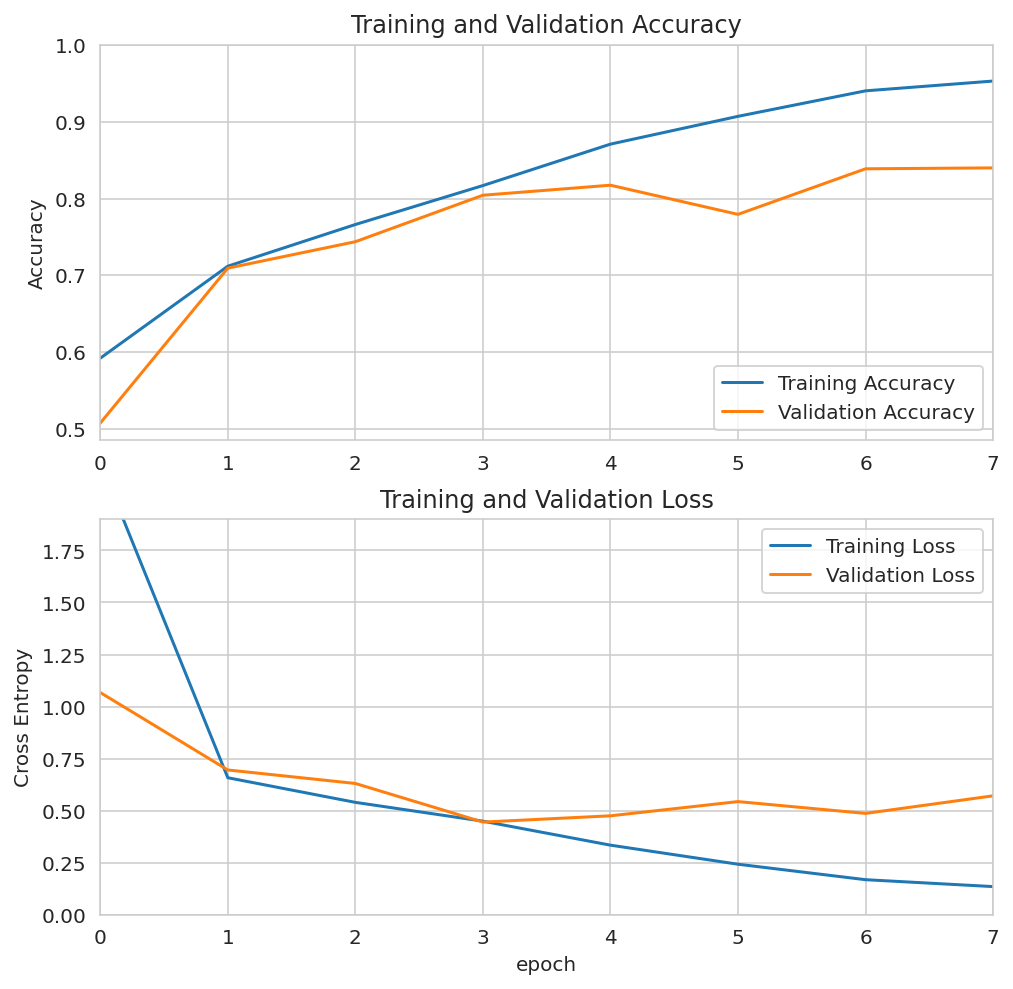

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlim([0,7])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.9])
plt.xlim([0,7])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Looks like base model @epoch 3 has the best generalisation. However base model @epoch 4 has the best loss function value, while still having good accuracy generalisation.

## Model with augmentation layers

adding data augmentation layers

In [ ]:
def U_Net_augmented(Image_Size):
    # Take the image size and shape
    input1 = tf.keras.Input(Image_Size)
    # data augmentation
    input1 = data_augmentation(input1)
    # rescale
    input1 = layers.Rescaling(1./255)(input1)

    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out_1 = Conv2D(4, 1, padding="same", activation="relu")(decoder_4)
    #final layers to force shape to suit binary label shapes
    flat = tf.keras.layers.Flatten()(out_1)
    out_2 = tf.keras.layers.Dense(4, activation='softmax')(flat)

    model = Model(input1, out_2)
    return model

In [ ]:
input_shape = (160, 160, 3)
model = U_Net_augmented(input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 160, 160, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 160, 160, 64  256        ['conv2d_19[1][0]']              
 ormalization)                  )                                                           

## Compile, fit model, run

In [ ]:
model.compile(optimizer='adam', 
              loss="categorical_crossentropy", # match label_mode='categorical'
              metrics=['accuracy','AUC',get_f1])

# Train the model, doing validation at the end of each epoch.
epochs = 20 # experience shows early stopping by epoch 15

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/UNet_augm_ep{epoch}_val{val_loss:.3f}", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4,min_delta=0.001,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/history_augm.csv') # save history
]

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
106/106 [==============================] - 992s 9s/step - loss: 1.2007 - accuracy: 0.6040 - auc: 0.8449 - get_f1: 0.5597 - val_loss: 1.1644 - val_accuracy: 0.4591 - val_auc: 0.7605 - val_get_f1: 0.1921
Epoch 2/20
106/106 [==============================] - 944s 9s/step - loss: 0.6987 - accuracy: 0.6858 - auc: 0.9113 - get_f1: 0.6578 - val_loss: 0.7254 - val_accuracy: 0.6940 - val_auc: 0.9088 - val_get_f1: 0.6606
Epoch 3/20
106/106 [==============================] - 931s 9s/step - loss: 0.6086 - accuracy: 0.7306 - auc: 0.9318 - get_f1: 0.7127 - val_loss: 1.1205 - val_accuracy: 0.6358 - val_auc: 0.8675 - val_get_f1: 0.6302
Epoch 4/20
106/106 [==============================] - 940s 9s/step - loss: 0.5336 - accuracy: 0.7842 - auc: 0.9483 - get_f1: 0.7676 - val_loss: 0.6053 - val_accuracy: 0.7331 - val_auc: 0.9348 - val_get_f1: 0.7300
Epoch 5/20
106/106 [==============================] - 935s 9s/step - loss: 0.4711 - accuracy: 0.7949 - auc: 0.9600 - get_f1: 0.7911 - val_loss: 0.55

## Learning Curves 

In [ ]:
history = pd.read_csv('drive/MyDrive/Colab Notebooks/history_augm.csv')
history.head(3)

,epoch,accuracy,auc,get_f1,loss,val_accuracy,val_auc,val_get_f1,val_loss
0,0,0.604031,0.844883,0.559700,1.200689,0.459075,0.760531,0.192124,1.164425
1,1,0.685833,0.911327,0.657847,0.698714,0.693950,0.908786,0.660627,0.725394
2,2,0.730587,0.931844,0.712663,0.608577,0.635824,0.867520,0.630157,1.120515


In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

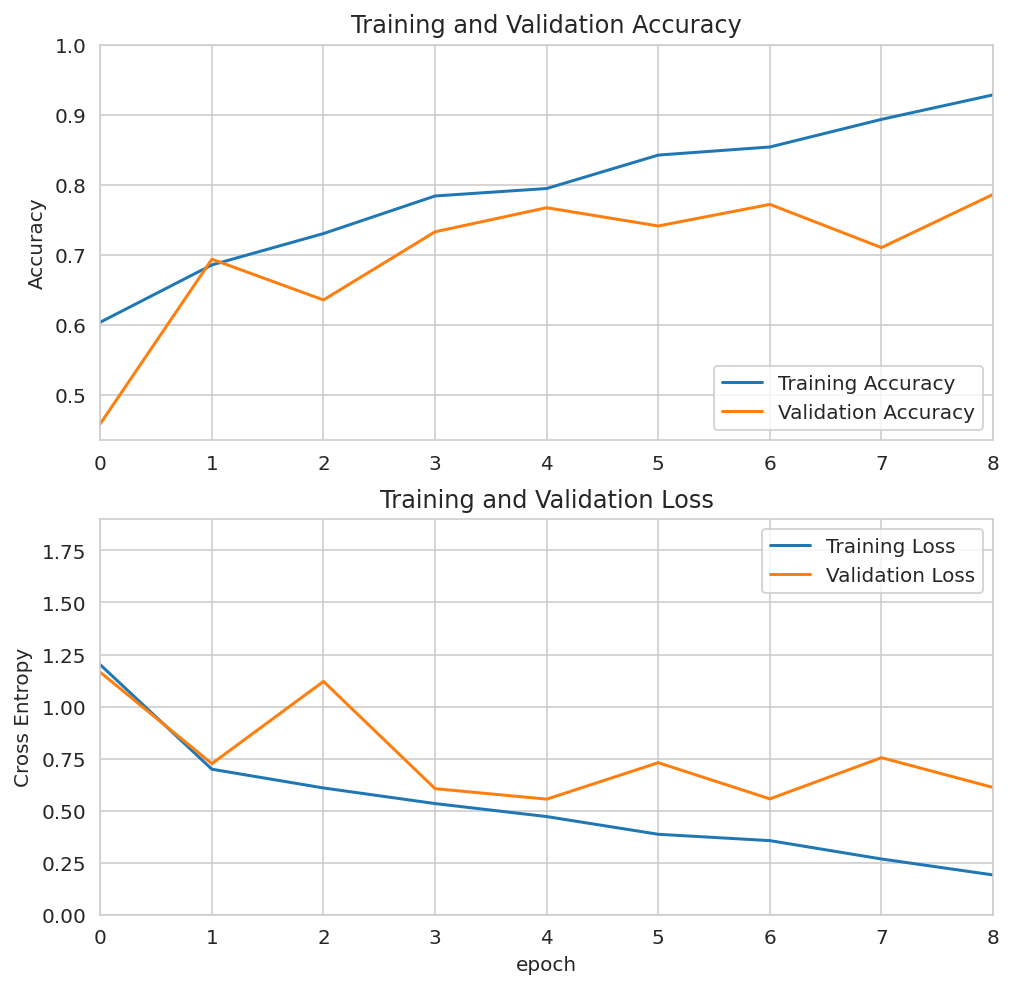

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlim([0,8])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.9])
plt.xlim([0,8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation metric results seem to show adding augmentation layers did not help with model learning significantly. Therefore, will try base model with SGD Optimiser to see if learning pattern can be improved.

## Try with SGD Optimiser, if get better performance
using augmented model

In [19]:
# if using base model
input_shape = (160, 160, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 64  256        ['conv2d[1][0]']                 
 alization)                     )                                                             

In [22]:
model.compile(optimizer='SGD', 
              loss="categorical_crossentropy", # match label_mode='categorical'
              metrics=['accuracy','AUC', get_f1])

# Train the model, doing validation at the end of each epoch.
epochs = 20

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/UNet_sgd_ep{epoch}_val{val_loss:.3f}", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4,min_delta=0.001,restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/history_sgd.csv') # save history
]

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
106/106 [==============================] - 1169s 11s/step - loss: 1.2053 - accuracy: 0.5655 - auc: 0.8158 - get_f1: 0.4481 - val_loss: 1.2385 - val_accuracy: 0.4923 - val_auc: 0.8066 - val_get_f1: 0.0224
Epoch 2/20
106/106 [==============================] - 1190s 11s/step - loss: 0.6889 - accuracy: 0.7012 - auc: 0.9152 - get_f1: 0.6723 - val_loss: 0.8025 - val_accuracy: 0.6845 - val_auc: 0.9035 - val_get_f1: 0.5412
Epoch 3/20
106/106 [==============================] - 1199s 11s/step - loss: 0.6173 - accuracy: 0.7404 - auc: 0.9324 - get_f1: 0.7261 - val_loss: 0.7043 - val_accuracy: 0.7034 - val_auc: 0.9174 - val_get_f1: 0.6279
Epoch 4/20
106/106 [==============================] - 1174s 11s/step - loss: 0.5473 - accuracy: 0.7739 - auc: 0.9462 - get_f1: 0.7607 - val_loss: 0.7866 - val_accuracy: 0.6595 - val_auc: 0.8927 - val_get_f1: 0.6490
Epoch 5/20
106/106 [==============================] - 1195s 11s/step - loss: 0.4847 - accuracy: 0.7976 - auc: 0.9574 - get_f1: 0.7892 - val_

Preliminary metrics seem to show that with SGD optimizer, the model is learning better and faster.

## Learning Curves 

In [23]:
history = pd.read_csv('drive/MyDrive/Colab Notebooks/history_sgd.csv')
history.head(3)

,epoch,accuracy,auc,get_f1,loss,val_accuracy,val_auc,val_get_f1,val_loss
0,0,0.565501,0.815795,0.448051,1.205263,0.492289,0.806591,0.022447,1.238541
1,1,0.701245,0.915173,0.672299,0.688851,0.684460,0.903497,0.541225,0.802453
2,2,0.740368,0.932390,0.726128,0.617250,0.703440,0.917411,0.627948,0.704324


In [24]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

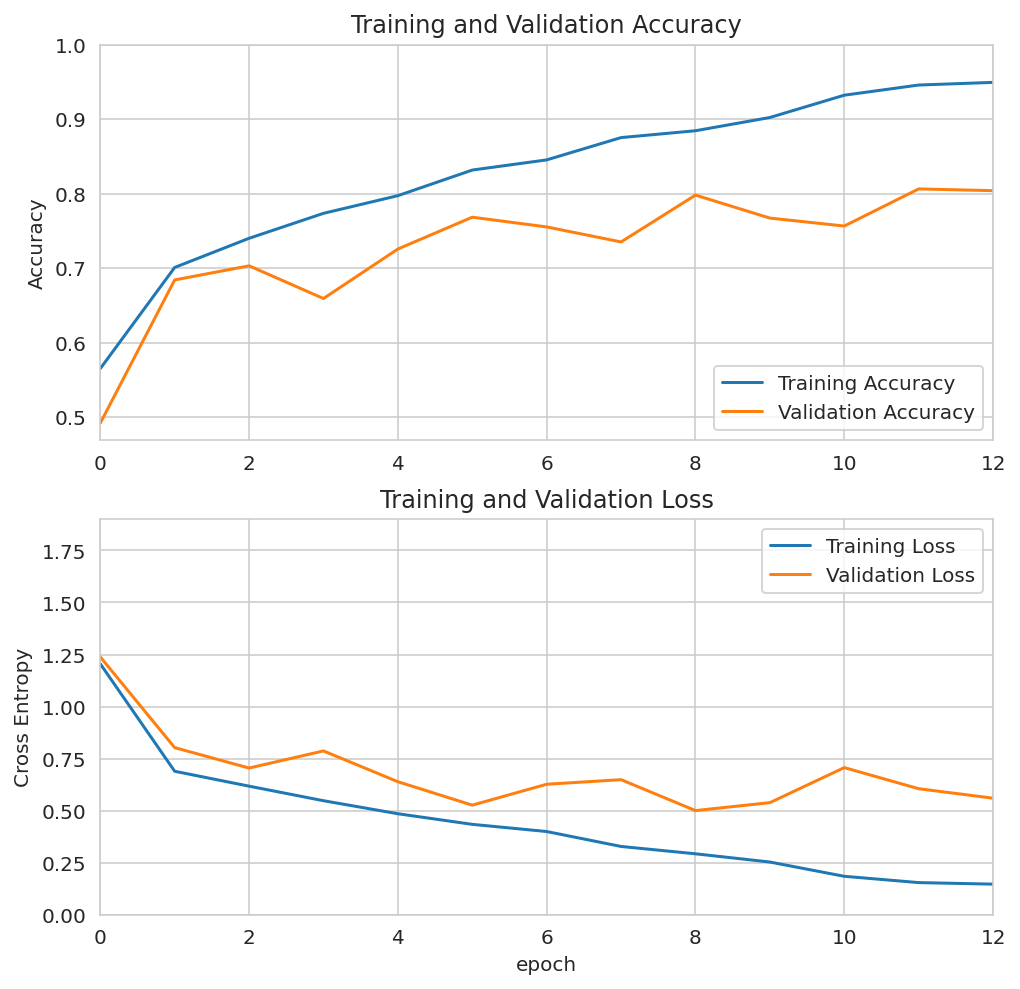

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlim([0,12])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.9])
plt.xlim([0,12])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Based on the metrics, it seems using SGD optimizer on augmented model causes model to become overfitted easily. Therefore I will use base model for evaluation as follows. 

## Evaluation

__References:__
1. [images](https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/)
1. [kaggle code](https://www.kaggle.com/code/gpiosenka/eye-disease-f1-score-92-6/notebook)

In [ ]:
# choose model for evaluation
# load model
model = tf.keras.models.load_model("drive/MyDrive/Colab Notebooks/UNet_ep4_val0.445")
